# Gestion de l'application Luis

### Table des matières

* [**1. Introduction**](#chapter1)
* [**2. Exploration des données**](#chapter2)
* [**3. Transformation du format**](#chapter3)
* [**4. Séparation train et test**](#chapter4)
* [**5. Création de l'appli Luis**](#chapter5)
* [**6. Entrainement du modèle**](#chapter6)
* [**7. Publication de l'appli Luis pour le test**](#chapter7)
* [**8. Evaluation du modèle**](#chapter8)
    * [8.1. Portail Luis](#section_8_1)
    * [8.2. Luis SDK](#section_8_2)
* [**9. Publication de l'appli Luis en production**](#chapter9)
* [**10. Création d'une nouvelle version pour mises à jours**](#chapter10)

## 1 - Introduction <a class="anchor" id="chapter1"></a>

Ce notebook permet  
- d'entrainer un modèle Luis à partir des données de Frames Dataset  
- de l'évaluer 
- de le publier  

In [44]:
import pandas as pd
import numpy as np
import datetime
import time
import json
import os
import matplotlib.pyplot as plt


## 2 - Exploration des données <a class="anchor" id="chapter2"></a>

In [2]:
df = pd.read_json("./frames/frames.json")


#### Aperçu des données:

In [3]:
df

,user_id,turns,wizard_id,id,labels
0,U22HTHYNP,[{'text': 'I'd like to book a trip to Atlantis...,U21DKG18C,e2c0fc6c-2134-4891-8353-ef16d8412c9a,"{'userSurveyRating': 4.0, 'wizardSurveyTaskSuc..."
1,U21E41CQP,"[{'text': 'Hello, I am looking to book a vacat...",U21DMV0KA,4a3bfa39-2c22-42c8-8694-32b4e34415e9,"{'userSurveyRating': 3.0, 'wizardSurveyTaskSuc..."
2,U21RP4FCY,[{'text': 'Hello there i am looking to go on a...,U21E0179B,6e67ed28-e94c-4fab-96b6-68569a92682f,"{'userSurveyRating': 2.0, 'wizardSurveyTaskSuc..."
3,U22HTHYNP,[{'text': 'Hi I'd like to go to Caprica from B...,U21DKG18C,5ae76e50-5b48-4166-9f6d-67aaabd7bcaa,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
4,U21E41CQP,"[{'text': 'Hello, I am looking to book a trip ...",U21DMV0KA,24603086-bb53-431e-a0d8-1dcc63518ba9,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
...,...,...,...,...,...
1364,U2AMZ8TLK,[{'text': 'Hi I've got 9 days free and I'm loo...,U21DMV0KA,957fd205-bb7c-4b81-8cb6-13c81c51c5c9,"{'userSurveyRating': 3.5, 'wizardSurveyTaskSuc..."
1365,U2AMZ8TLK,[{'text': 'I need to get to Fortaleza on Septe...,U260BGVS6,71b21b86-2d05-4372-a0ee-6ed64b0ddc42,"{'userSurveyRating': 4.5, 'wizardSurveyTaskSuc..."
1366,U231PNNA3,[{'text': 'We're finally going on vacation isn...,U21T9NMKM,ef2cd70e-c1f2-42be-8839-cb465af0bf41,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
1367,U2AMZ8TLK,"[{'text': 'Hi there, I'm looking for a place t...",U21DMV0KA,ffa79d2c-14eb-45e6-8573-b0817a1a1803,"{'userSurveyRating': 4.0, 'wizardSurveyTaskSuc..."


#### Aperçu des colonnes turns et labels:

In [4]:
df['labels'][0]

{'userSurveyRating': 4.0, 'wizardSurveyTaskSuccessful': True}

In [53]:
df['turns'][0][0]

{'text': "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
 'labels': {'acts': [{'args': [{'val': 'book', 'key': 'intent'}],
    'name': 'inform'},
   {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
     {'val': 'Caprica', 'key': 'or_city'},
     {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
     {'val': '8', 'key': 'n_adults'},
     {'val': '1700', 'key': 'budget'}],
    'name': 'inform'}],
  'acts_without_refs': [{'args': [{'val': 'book', 'key': 'intent'}],
    'name': 'inform'},
   {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
     {'val': 'Caprica', 'key': 'or_city'},
     {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
     {'val': '8', 'key': 'n_adults'},
     {'val': '1700', 'key': 'budget'}],
    'name': 'inform'}],
  'active_frame': 1,
  'frames': [{'info': {'intent': [{'val': 'book', 'negated': False}],
     'budget': [{'val': '1700.0', 'negated': False}],
     'dst_city': [{

La colonne turns contient les dialogues utilisateurs ainsi que les informations étiquetées.  
Le premier turn de chaque userid correspond à la demande initiale de l'utilisateur.

#### Liste des intents des demandes initiales:

In [6]:
intents_list = []

for idx, turn in enumerate(df['turns']):
    for act in turn[0]['labels']['acts']:
        for arg in act['args']:
            if arg['key'] == 'intent':
                if arg['val'] not in intents_list:
                    intents_list.append(arg['val'])

intents_list

['book']

#### Liste des entités:

In [7]:
keys_list = []

for idx, turn in enumerate(df['turns']):
    for act in turn[0]['labels']['acts']:
        for arg in act['args']:
            if arg['key'] not in keys_list:
                keys_list.append(arg['key'])

keys_list
    

['intent',
 'dst_city',
 'or_city',
 'str_date',
 'n_adults',
 'budget',
 'end_date',
 'n_children',
 'max_duration',
 'breakfast',
 'flex',
 'price',
 'name',
 'beach',
 'seat',
 'category',
 'min_duration',
 'park',
 'count_dst_city',
 'university',
 'ref']

#### Liste des entités des turns avec une intent:

In [8]:
keys_list = []

for idx, turn in enumerate(df['turns']):
    for act in turn[0]['labels']['acts']:
        intentFound = False
        temp = keys_list.copy()
        for arg in act['args']:
            if arg['key'] == 'intent':
                intentFound = True                
            if arg['key'] not in temp:
                temp.append(arg['key'])
        if intentFound:
            keys_list = temp.copy()
            
keys_list   


['intent',
 'str_date',
 'end_date',
 'dst_city',
 'breakfast',
 'or_city',
 'n_adults',
 'n_children',
 'budget',
 'max_duration',
 'flex']

Les entités : str_date, end_date, dst_city, or_city, budget correspondent au besoin.

## 3 - Transformation du format <a class="anchor" id="chapter3"></a>

#### transformation du format des données du dataset frames au format Luis

In [9]:
labeledExampleUtteranceWithMLEntities = []
entity_list = ['dst_city', 'or_city', 'str_date', 'end_date', 'budget']

for idx, turn in enumerate(df['turns']):
    labeledExampleUtteranceWithMLEntity  = {}
    entityLabels=[]
    intentFound = False
    labeledExampleUtteranceWithMLEntity['text'] = turn[0]['text']
    for act in turn[0]['labels']['acts']:
        if act['name'] == 'inform': # contains arg with key and val, text which inform what user wants  
            for arg in act['args']:
                if arg['key'] == 'intent':
                    intentFound = True
                    labeledExampleUtteranceWithMLEntity['intentName'] = arg['val']
                else:
                    if arg['key'] in entity_list:
                        arg_val = str(arg['val'])
                        entityLabel={}
                        entityLabel['entityName'] = arg['key']
                        entityLabel['startCharIndex'] = turn[0]['text'].find(arg_val)
                        entityLabel['endCharIndex'] = int(entityLabel['startCharIndex']) + int(len(arg_val)) - 1
                        if entityLabel['startCharIndex']>0 and entityLabel['endCharIndex']>0:
                            entityLabels.append(entityLabel)
    labeledExampleUtteranceWithMLEntity['entityLabels'] = entityLabels
    if intentFound:
        labeledExampleUtteranceWithMLEntities.append(labeledExampleUtteranceWithMLEntity)


In [10]:
df_datas = pd.DataFrame(labeledExampleUtteranceWithMLEntities)

In [11]:
df_datas

,text,intentName,entityLabels
0,I'd like to book a trip to Atlantis from Capri...,book,"[{'entityName': 'dst_city', 'startCharIndex': ..."
1,"Hello, I am looking to book a vacation from Go...",book,"[{'entityName': 'dst_city', 'startCharIndex': ..."
2,Hello there i am looking to go on a vacation w...,book,"[{'entityName': 'dst_city', 'startCharIndex': ..."
3,"Hi I'd like to go to Caprica from Busan, betwe...",book,"[{'entityName': 'dst_city', 'startCharIndex': ..."
4,"Hello, I am looking to book a trip for 2 adult...",book,"[{'entityName': 'budget', 'startCharIndex': 67..."
...,...,...,...
1131,Hi I've got 9 days free and I'm looking for a ...,book,"[{'entityName': 'or_city', 'startCharIndex': 6..."
1132,I need to get to Fortaleza on September 8th or...,book,"[{'entityName': 'dst_city', 'startCharIndex': ..."
1133,We're finally going on vacation isn't that ama...,book,"[{'entityName': 'budget', 'startCharIndex': 75..."
1134,"Hi there, I'm looking for a place to get away ...",book,[]


#### Vérification des intents et entités:

In [12]:
def get_entities_list(datas):
    entities_list = []
    df = pd.DataFrame(datas)
    for entityLabels in df['entityLabels']:
        for entityLabel in entityLabels:
            if entityLabel['entityName'] not in entities_list:
                entities_list.append(entityLabel['entityName'])
    return entities_list

In [13]:
entities_list = get_entities_list(labeledExampleUtteranceWithMLEntities)
entities_list

['dst_city', 'or_city', 'str_date', 'budget', 'end_date']

In [14]:
df_datas.intentName.unique()

array(['book'], dtype=object)

## 4 - Train test split <a class="anchor" id="chapter4"></a>

#### Séparation en jeu d'entrainement et de test et sauvegarde des données de test

In [15]:
def train_test_split(datas, train_ratio):
    datas_len = len(datas)  
    datas_train_len = round(datas_len * train_ratio)   
    return datas[:datas_train_len], datas[datas_train_len:]
    

In [16]:
train_ratio = 0.7

In [17]:
train_datas, test_datas = train_test_split(labeledExampleUtteranceWithMLEntities,train_ratio)

In [18]:

with open('./datas_train.json', 'w') as fp:
    json.dump(train_datas, fp)
    
with open('./datas_test.json', 'w') as fp:
    json.dump(test_datas, fp)    


#### Vérification des entités et des intents:

In [19]:
entities_list = get_entities_list(train_datas)
entities_list

['dst_city', 'or_city', 'str_date', 'budget', 'end_date']

In [20]:
entities_list = get_entities_list(test_datas)
entities_list

['dst_city', 'or_city', 'str_date', 'end_date', 'budget']

In [21]:
pd.DataFrame(train_datas).intentName.unique()

array(['book'], dtype=object)

In [22]:
pd.DataFrame(test_datas).intentName.unique()

array(['book'], dtype=object)

## 5 - Création de l'application luis <a class="anchor" id="chapter5"></a>

In [23]:
from azure.cognitiveservices.language.luis.authoring import LUISAuthoringClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.language.luis.runtime import LUISRuntimeClient


In [24]:
authoring_end_point = "https://luisylbot-authoring.cognitiveservices.azure.com/"
# authoring_end_point = "https://westeurope.api.cognitive.microsoft.com"

luis_authoring_key = os.environ.get("LuisAuthKey")
default_app_name = "flymebot-{}".format(datetime.datetime.now())
version_id = "0.1"
description = "New App created with LUIS Python sample"

In [25]:
client = LUISAuthoringClient(
    authoring_end_point,
    CognitiveServicesCredentials(luis_authoring_key),
)

In [26]:
app_id = client.apps.add({
            'name': default_app_name,
            'initial_version_id': version_id,
            'description': description,
            'culture': 'en-us',
        })

In [27]:

client.model.add_intent(app_id, version_id, 'book')    

entities_list = ['dst_city', 'or_city', 'str_date', 'budget', 'end_date']
for entity_name in entities_list:
    result = client.model.add_entity(app_id, version_id, name=entity_name)



## 6 - Entrainement du modèle <a class="anchor" id="chapter6"></a>

In [28]:
with open('./datas_train.json', 'r') as fp:
    datas_train = json.load(fp)

In [29]:
    
batch_size = 100
begin_batch = 0 
end_batch = batch_size

while end_batch < len(datas_train):
    result = client.examples.batch(app_id, version_id, datas_train[begin_batch:end_batch])
    begin_batch += batch_size
    end_batch += batch_size
    
result = client.examples.batch(app_id, version_id, datas_train[begin_batch:len(datas_train)])
    

In [30]:
async_training = client.train.train_version(app_id, version_id)

is_trained = async_training.status == "UpToDate"

trained_status = ["UpToDate", "Success"]
while not is_trained:
    time.sleep(1)
    status = client.train.get_status(app_id, version_id)
    is_trained = all(
        m.details.status in trained_status for m in status)

print("Your app is trained. You can now go to the LUIS portal and test it!")

Your app is trained. You can now go to the LUIS portal and test it!


## 7 - Publication de l'application luis pour test <a class="anchor" id="chapter7"></a>

#### Publication de l'application sur le slot staging

In [31]:
result = client.apps.update_settings(app_id, is_public=True)

publish_result = client.apps.publish(
        app_id, "0.1", is_staging=True, region='westeurope')

endpoint = publish_result.endpoint_url + \
        "?subscription-key=" + luis_authoring_key + "&q="

print("Your app is published. You can now go to test it on\n{}".format(endpoint))

Your app is published. You can now go to test it on
https://westeurope.api.cognitive.microsoft.com/luis/v2.0/apps/5659238b-01c3-4538-aa7f-cec19dbca50a?subscription-key=6a35ccafcbde43d98fefc3ba7f4e334a&q=


## 8 - Evaluation du modèle <a class="anchor" id="chapter8"></a>

L'application peut être testée :  

    1 -  Sur le portail luis.ai à l'aide d'un fichier test    
    2 -  A l'aide de Luis sdk une fois publiée (sur le slot staging)    

### 8.1 - Test sur le portail luis.ai <a class="anchor" id="section_8_1"></a>

Formatage des clés au format luis.ai

In [32]:

def format_test_luiai(datas):
    for data in datas:
        data["intent"] = data.pop("intentName")
        data["entities"] = data.pop("entityLabels")
        for entity in data["entities"]:
            entity["entity"] = entity.pop("entityName")
            entity["startPos"] = entity.pop("startCharIndex")
            entity["endPos"] = entity.pop("endCharIndex")
    return datas


In [33]:
with open('./datas_test.json', 'r') as fp:
    datas_test_to_format = json.load(fp)
    
datas_tests_luisai = format_test_luiai(datas_test_to_format)

with open('./datas_tests_luisai.json', 'w') as fp:
    json.dump(datas_tests_luisai, fp)

Importer le fichier généré dans luis.ai

### 8.2 - Test avec Luis sdk <a class="anchor" id="section_8_2"></a>

In [39]:
from sklearn.metrics import classification_report

list_entities = ['dst_city', 'or_city', 'str_date', 'end_date', 'budget']

def test_entities(datas_test):
    dict_true_pred = {}
    dict_true_pred['target'] = []
    dict_true_pred['pred'] = []
    dict_true_pred['pred_class'] = []

    for data_test in datas_test:
        query = data_test['text']
        response_entities = get_entities_from_luis(query)

        current_test_values = {}
        for entity_label in data_test['entityLabels']:
            entity_name = entity_label['entityName']
            entity_value = get_entity_value(query, entity_label)
            current_test_values[entity_name] = entity_value

        for entity_name in list_entities:
            if entity_name in current_test_values:
                dict_true_pred['target'].append(entity_name)
                if entity_name in response_entities:
                    dict_true_pred['pred_class'].append(entity_name)
                    if current_test_values[entity_name] == response_entities[entity_name][0]:
                        dict_true_pred['pred'].append(entity_name)
                    else:
                        dict_true_pred['pred'].append("")
                else:
                    dict_true_pred['pred'].append("")
                    dict_true_pred['pred_class'].append("")
            else:
                if entity_name in response_entities:
                    dict_true_pred['target'].append("")
                    dict_true_pred['pred'].append(entity_name)
                    dict_true_pred['pred_class'].append(entity_name)
                    
    return pd.DataFrame(dict_true_pred)     


def stats_recall_entities(df_entities, col_pred = 'pred'):

    stats_rec = {}
    for entity in list_entities:
        stats_rec[entity] = {}
        stats_rec[entity]['target'] = 0
        stats_rec[entity]['found'] = 0    

    for index, row in df_entities.iterrows(): 
        entity_name = row['target']
        if entity_name != '':
            stats_rec[entity_name]['target'] += 1
            if entity_name == row[col_pred]:
                stats_rec[entity_name]['found'] += 1
                
    df_stats_rec = pd.DataFrame(stats_rec).T
    df_stats_rec['recall'] = round(df_stats_rec['found'] / df_stats_rec['target'],2) * 100                

    return df_stats_rec


def send_query_to_luis(query, app_id = app_id, slot_name = "Staging"):
    predictionRequest = { "query" : query }
    response = clientRuntime.prediction.get_slot_prediction(app_id, slot_name, predictionRequest)
    return response

def get_entity_value(query, entity_label):
    start = entity_label['startCharIndex']
    end = entity_label['endCharIndex']+1
    entity_value = query[start:end]
    return entity_value

    
def get_entities_from_luis(query, app_id = app_id, slot_name = "Staging"):
    response = send_query_to_luis(query)
    return response.prediction.entities

                

#### Création du runtime client:

In [35]:
# prediction_endpoint = "https://luisylbot.cognitiveservices.azure.com/"
prediction_endpoint = "https://westeurope.api.cognitive.microsoft.com"
prediction_key = os.environ.get("LuisPredKey")
runtimeCredentials = CognitiveServicesCredentials(prediction_key)
clientRuntime = LUISRuntimeClient(endpoint=prediction_endpoint, credentials=runtimeCredentials)


In [36]:
# test runtime

predictionRequest = { "query" : "I want travel from Paris to berlin from August 18 2022 to August 29 with budget of 500$" }
response = clientRuntime.prediction.get_slot_prediction(app_id, "Staging", predictionRequest)

print("Intents: ")
for intent in response.prediction.intents:
    print("\t{}".format (json.dumps (intent)))
    
print("Entities: \n\t{}".format (response.prediction.entities))

Intents: 
	"book"
Entities: 
	{'or_city': ['Paris'], 'dst_city': ['berlin'], 'str_date': ['August 18 2022'], 'end_date': ['August 29'], 'budget': ['500$']}


#### Evaluation du modèle:

In [37]:
with open('./datas_test.json', 'r') as fp:
    datas_test = json.load(fp)

In [40]:
df_entities =  test_entities(datas_test)
df_entities[:10]

,target,pred,pred_class
0,dst_city,dst_city,dst_city
1,dst_city,dst_city,dst_city
2,dst_city,dst_city,dst_city
3,dst_city,dst_city,dst_city
4,dst_city,,
5,,dst_city,dst_city
6,or_city,,
7,dst_city,dst_city,dst_city
8,or_city,or_city,or_city
9,dst_city,dst_city,dst_city


In [41]:
y_true = np.array(df_entities['target'])
y_pred = np.array(df_entities['pred'])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

                   0.00      0.00      0.00        13
      budget       0.98      0.90      0.94        51
    dst_city       0.98      0.89      0.93       225
    end_date       0.97      0.71      0.82        42
     or_city       0.97      0.90      0.94       185
    str_date       0.98      0.60      0.74        67

    accuracy                           0.83       583
   macro avg       0.81      0.67      0.73       583
weighted avg       0.95      0.83      0.88       583



#### Affichage du recall

In [42]:
df_stats_rec = stats_recall_entities(df_entities)
df_stats_rec

,target,found,recall
dst_city,225,200,89.0
or_city,185,167,90.0
str_date,67,40,60.0
end_date,42,30,71.0
budget,51,46,90.0


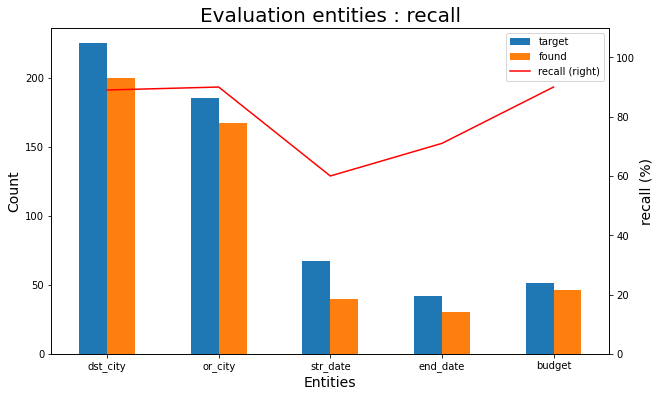

In [45]:
fig, ax = plt.subplots(figsize=(10,6))

df_stats_rec[['target','found']].plot(
    use_index=True, 
    kind='bar',
    ax=ax, 
)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Entities', fontsize=14)

df_stats_rec.plot(
    use_index=True, 
    y='recall', 
    ax=ax, 
    secondary_y=True, 
    color='red'
)
plt.ylabel('recall (%)', fontsize=14)
plt.ylim(0, 110)
plt.title('Evaluation entities : recall', fontsize=20)


plt.show()

## 9 - Publication de l'application luis en production <a class="anchor" id="chapter9"></a>

In [46]:
publish_result = client.apps.publish(
        app_id, "0.1", is_staging=False, region='westeurope')

endpoint = publish_result.endpoint_url + \
        "?subscription-key=" + luis_authoring_key + "&q="

print("Your app is published. You can now go to test it on\n{}".format(endpoint))

Your app is published. You can now go to test it on
https://westeurope.api.cognitive.microsoft.com/luis/v2.0/apps/5659238b-01c3-4538-aa7f-cec19dbca50a?subscription-key=6a35ccafcbde43d98fefc3ba7f4e334a&q=


## 10 - Nouvelle version pour mises à jour <a class="anchor" id="chapter10"></a>

In [47]:
# Cloning a version
print("\nCloning version 0.1 into 0.2")
client.versions.clone(
    app_id,
    "0.1",  # Source
    "0.2"   # New version name
)
print("Your app version has been cloned.")



Cloning version 0.1 into 0.2
Your app version has been cloned.


In [48]:
publish_result = client.apps.publish(
        app_id, "0.2", is_staging=True, region='westeurope')

endpoint = publish_result.endpoint_url + \
        "?subscription-key=" + luis_authoring_key + "&q="

print("Your app is published. You can now go to test it on\n{}".format(endpoint))


Your app is published. You can now go to test it on
https://westeurope.api.cognitive.microsoft.com/luis/v2.0/apps/5659238b-01c3-4538-aa7f-cec19dbca50a?subscription-key=6a35ccafcbde43d98fefc3ba7f4e334a&q=
